# Machine Learning Engineer Nanodegree
## Capstone Project - Starbucks Coffee Coupon
Leo Li  
December 26th, 2019

## I. Definition
### Project Overview
#### The Dataset
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. 
Once every few days, Starbucks sends out an offer to users of the mobile app. 
An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). 
Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. 
You'll see in the data set that informational offers have a validity period even though these ads are merely providing 
information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer 
is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the 
amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as 
well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer 
or seen an offer.

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product 
whereas Starbucks actually sells dozens of products.

#### The Task
Your task is to combine `transaction`, `demographic` and `offer` data to determine which demographic groups (a.k.a what
kind of consumers) respond best to which offer type. 

#### Problem Statement
This is a supervised learning classification problem. Specifically, it is a `multi-label classification` problem.

- ##### Here is a brief description of the problem

    - We have 8 different types of coupons(except for 2 informational coupon). For each consumer, during the given time 
    period of 30 days, we know if a user has `successfully used a coupon`. Since a consumer can be given multiple coupon
     (these events are not exclusive to each other), it is a `multi-label binary classificatio` problem.
 
- ##### Definition of `successfuly used a coupon`:
    - The consumer has to view the coupon, and then within the effective duration of the coupon, complete it.

A successful model can predict how likely a consumer will use one of the 8 types of coupons, so that it helps Starbucks
 to send promotion to the target consumer, and, of course, capture to most value out of the person.

### Metrics
### ROC_AUC
Since it is a binary classfication problem, we will evaluate with `Area under the Curve (AUC) of Receiver Operating 
Characteristic (ROC) `

<img src="https://miro.medium.com/max/722/1*pk05QGzoWhCgRiiFbz-oKQ.png" width="400">


source: 

[understanding-auc-roc-curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

### Recall

We would rather give coupon to a consumer, even he / she won't use it, than missing a consumer that are potentially 
buying coffee. So recall is a more important measure than precision

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="400">

source: [Recall definition from Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

### Feature Importance

We will also run a `feature importance analysis` on the features. This can be done using `sklearn` - 
`randomForestClassifier` - `feature_importances_`

## II. Analysis

### Data Exploration & Visualization


In [1]:
!python --version

Python 3.7.5


In [2]:
import pandas as pd
import numpy as np
import math
import json
import warnings

from helper.plot import plot_hist

warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('assets/portfolio.json', orient='records', lines=True)
profile = pd.read_json('assets/profile.json', orient='records', lines=True)
transcript = pd.read_json('assets/transcript.json', orient='records', lines=True)

### Data Sets

#### Portfolio Data Exploration & Visualization

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [3]:
portfolio.set_index('id', inplace=True)
portfolio

,reward,channels,difficulty,duration,offer_type
id,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo


Things that are interesting to us are:

- `difficulty`: how much do you need to spend to trigger the reward;

- `duration`: maximum time for the user to complete the offer;

- `offer_type`: Buy one get one free or just discount

- `channel & offer_type`: Since these information is catergorical, we would want to one-hot encode them, this will
    be the strategy for all other catergorical data

We know that there are 10 different offers, and `8` of them are actually coupons (we don't care about informational).

- Offer types are our `target data`. In the end, we want need a True / False (1 & 0) Table for each coupon map to each user



#### Consumer Profile Data Exploration & Visualization

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [4]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


There are some profile data that is invalid, let's see how many entry are there.

In [5]:
profile.set_index('id', inplace=True)

In [6]:
print(profile[profile['age'] == 118].shape)
print(profile[profile['income'].isnull()].shape)
print(profile[profile['gender'].isnull()].shape)

(2175, 4)
(2175, 4)
(2175, 4)


##### Histogram of profile

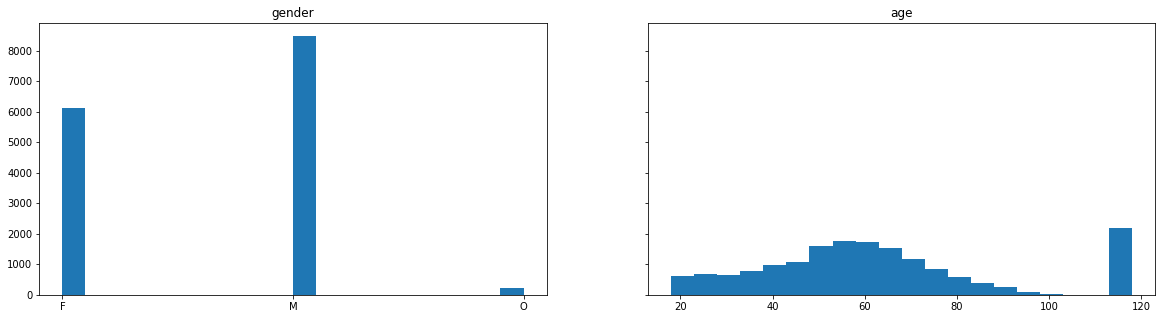

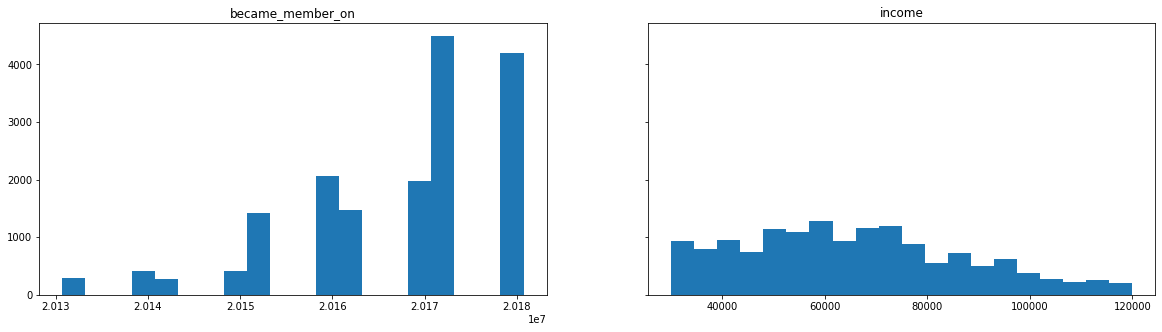

In [7]:
plot_hist(profile)

#### Transcript Data Exploration & Visualization

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
print(transcript.shape)

(306534, 4)


There are a lot of information we can gain from `transcript` dataframe

let's see what `event` type and `time` mean

##### Histogram of Transcript

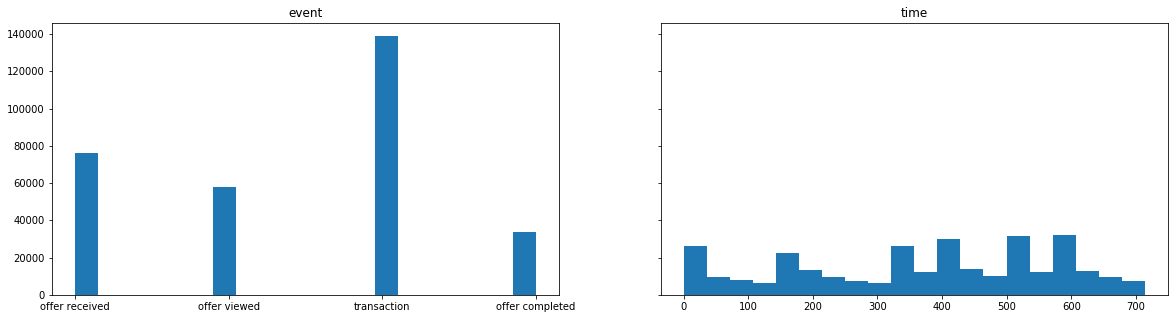

In [10]:
plot_hist(transcript[['event', 'time']])

We can see there are 4 types of events.

- `offer received`: the event that the consumer received an offer, value is offer id(same for offer viewed ans completed)
- `offer viewed`: the event that the consumer received an offer, this is necessary for successfully complete an offer
- `offer completed`: the event that the consumer complete an offer, this is necessary for successfully complete an offer
- `transaction`: the event that the consumer make a purchase, value column shows the amount

In [11]:
transcript[transcript['event'] == 'offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript[transcript['event'] == 'offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [13]:
transcript[transcript['event'] == 'offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [14]:
transcript[transcript['event'] == 'transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


### Algorithms and Techniques

We will be using the following algorithms:

- Data Cleaning: clean and one hot encoding our dataframe
    - clean_portfolio
    - clean_profile
    - clean_transcript 
    
    
- Data Creation: generate necessary data for training our model
    - generate_consumer_trend
        - based on the transcipts, organize consumer spending by day
    - generate_view_and_complete_day_df
        - based on the transcipts, organize consumer view and complete event by day
    - generate_target
        - based on consumer view and complete data, generate the valid complete target data
    - generate_coupon_sensitivity
        This is a complex algorithm to generate a feature called: coupon sensitivity, explained in the later section
        - get_days_not_affect_by_coupon
        - cal_avg_spend_without_coupon
        - generate_consumer_spending_couponx 


### Benchmark

Use `K-nearest neighbor` model as it is a fast and standard method for binary classification machine learning problems.

Reason for using KNN: It provides a quick way to train the model and test the result.

That being said, a quick and fairly accurate model will make it a good benchmark model.

## 3. Methodology
### Data Pre-Processing

In [15]:
from helper.data_cleaning import clean_portfolio, clean_profile, clean_transcript, generate_consumer_trend, \
generate_view_and_complete_day_df, generate_target, get_days_not_affect_by_coupon, cal_avg_spend_without_coupon, \
generate_consumer_spending_couponx, generate_coupon_sensitivity

#### Portfolio
Perform the following steps to preprocess the data.

- Rename "id" to "offer_id"
- Drop "informational" offer type
- One Hot Encode `offer type` and `channels`

In [16]:
portfolio = clean_portfolio('assets/portfolio.json')

In [17]:
portfolio

,reward,difficulty,duration,bogo,discount,email,mobile,web,social
offer_id,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1.0,0.0,1.0,1.0,0.0,1.0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1.0,0.0,1.0,1.0,1.0,1.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1.0,0.0,1.0,1.0,1.0,0.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0.0,1.0,1.0,0.0,1.0,0.0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,0.0,1.0,1.0,1.0,1.0,1.0
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0.0,1.0,1.0,1.0,1.0,1.0
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1.0,0.0,1.0,1.0,1.0,1.0
2906b810c7d4411798c6938adc9daaa5,2,10,7,0.0,1.0,1.0,1.0,1.0,0.0


#### Profile
Perform the following steps to clean and preprocess the data.

- Rename "id" to "consumer_id"
- Drop all `nan` data
- Drop "gender" that are in the `O` catergory
- Split date into `year`, `month`, `day`
- One Hot Encode `date`, `gender`, `age` and `income`

In [18]:
profile = clean_profile('assets/profile.json')

In [19]:
profile.head()

,2013,2014,2015,2016,2017,2018,01,02,03,04,...,30000-40000,40000-50000,50000-60000,60000-70000,70000-80000,80000-90000,90000-100000,100000-110000,110000-120000,120000-130000
consumer_id,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
e2127556f4f64592b11af22de27a7932,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
389bc3fa690240e798340f5a15918d5c,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print(profile.shape)

(14613, 40)


#### Transaction

For transaction, first perform the following steps to clean and preprocess the data.

- rename `person` to `consumer_id`
- rename `value` to `offer_id` and reformat the value
- remove `{}` and `amount`, `offer_id` keys from the event column, keep only the values

In [21]:
transcript = clean_transcript('assets/transcript.json')
transcript

,consumer_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53


Then, we can generate two important dataframes.

- ##### 1. Target table
    - for each type of coupon, we can calculate if a consumer has successfully complete that offer. Thus we will have a True / False Table.
    

- ##### 2. Consumer Spending Trend
    - For each consumer, we can calculate the consumer's spending trend
    
In the following sections, I will discuss the implementation process

### Implementation

##### 1. Target table

How do we decide if a consumer `SUCCESSFULLY` used a coupon?

Here is the algorithm:

The consumer has to first `view` the coupon and then `complete` the coupon within the allowed time.
We will use the `viewed` and `completed` information from the `transcript` table, then for each `viewed`, we calculate if the consumer `completed` the coupon within its duration.

Perform the following steps:

- Calculate a table on what day does the consumer viewed a specific coupon
- Calculate a table on what day does the consumer completed a specific coupon
- Based on these two table, caculate if the specific coupon is a valid completion, the definition of a valid completion:
    `day of completed - day of viewed < duration`
    
We will use the helper function `generate_view_and_complete_day_df` to do so. This function will take the transcript and
return the a dataframe for every consumer's viewing activity each day, as well as a dataframe for offer completion.

We need these two dataframes to get the `valid completion` (target) dataframe

In [22]:
viewed_trend_day_df, completed_trend_day_df = generate_view_and_complete_day_df(transcript)

In [23]:
print(viewed_trend_day_df.shape)
viewed_trend_day_df.head()

(16907, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
consumer_id,,,,,,,,,,,,,,,,,,,,,
085efb39e80140f08b90e0d77299958b,0b1e1539f2cc45b7b9fa7c272da2e1d7,,,,,,,2906b810c7d4411798c6938adc9daaa5,,,...,,f19421c1d4aa40978ebb69ca19b0e20d,,,,0b1e1539f2cc45b7b9fa7c272da2e1d7,,,,
5ba3a50bd56d4309954af2555b32e536,,,,,,,,,,,...,,f19421c1d4aa40978ebb69ca19b0e20d,,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,,,
0eed1b43c7924182a635f0597fdf2adf,,,,,,,,,,,...,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,f19421c1d4aa40978ebb69ca19b0e20d,,,,,
c9eed1f79316414183383096b7a95347,,,,,,,,,,,...,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,,
341d5d291e4d413ebea827b44c57fe4a,ae264e3637204a6fb9bb56bc8210ddfd,,,,,,,2906b810c7d4411798c6938adc9daaa5,,,...,,3f207df678b143eea3cee63160fa8bed,,,f19421c1d4aa40978ebb69ca19b0e20d,,,,,


In [24]:
print(completed_trend_day_df.shape)
completed_trend_day_df.head()

(16907, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
consumer_id,,,,,,,,,,,,,,,,,,,,,
085efb39e80140f08b90e0d77299958b,,,,,,,,,,,...,,,f19421c1d4aa40978ebb69ca19b0e20d,,,,,,,
5ba3a50bd56d4309954af2555b32e536,,,,,,,,,,,...,,,,,,,,,,
0eed1b43c7924182a635f0597fdf2adf,,,,,,,,,,,...,,,,,,,,,,
c9eed1f79316414183383096b7a95347,,,,,,,,,,,...,,,,,,,,2298d6c36e964ae4a3e7e9706d1fb8c2,,
341d5d291e4d413ebea827b44c57fe4a,,,,,,,,,,,...,,,,,,,,,,


Then we can use `generate_target` function to get the target data

In [25]:
target_coupon = generate_target(viewed_trend_day_df, completed_trend_day_df, portfolio)
target_coupon

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
consumer_id,,,,,,,,
085efb39e80140f08b90e0d77299958b,0,0,0,0,0,0,1,0
5ba3a50bd56d4309954af2555b32e536,0,0,0,0,0,0,0,0
0eed1b43c7924182a635f0597fdf2adf,0,0,0,0,0,0,0,0
c9eed1f79316414183383096b7a95347,0,0,0,0,1,0,0,0
341d5d291e4d413ebea827b44c57fe4a,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
c62168760f1642cc89a1b884409d50c9,0,0,1,0,0,0,0,1
52373a9fea6348d583b6e4fb8c20e34a,0,0,0,0,0,0,0,0
0cb086ad62d34af1b8a3fc1860e4215f,0,0,0,0,0,0,0,0


Let's take a quick look at how the data look like

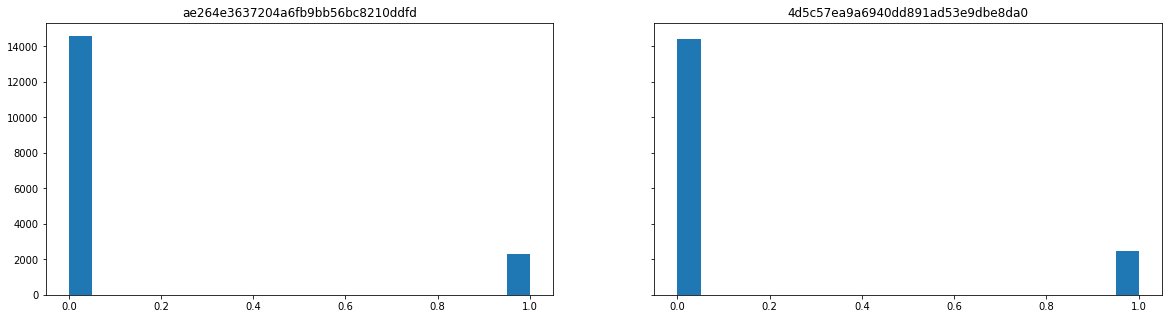

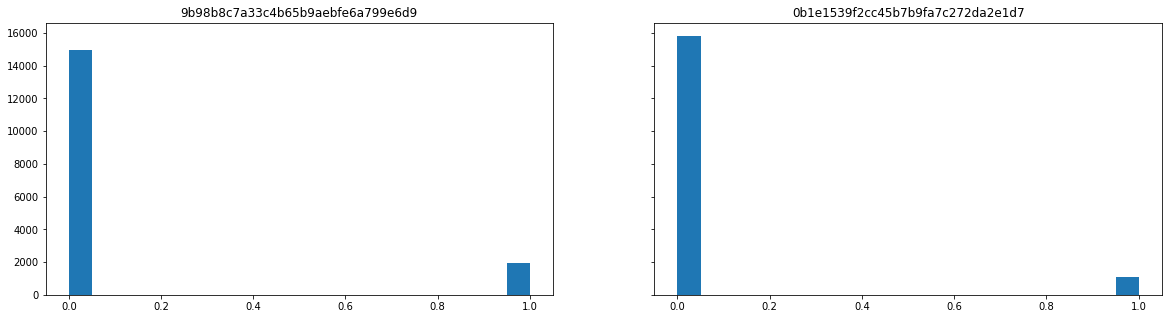

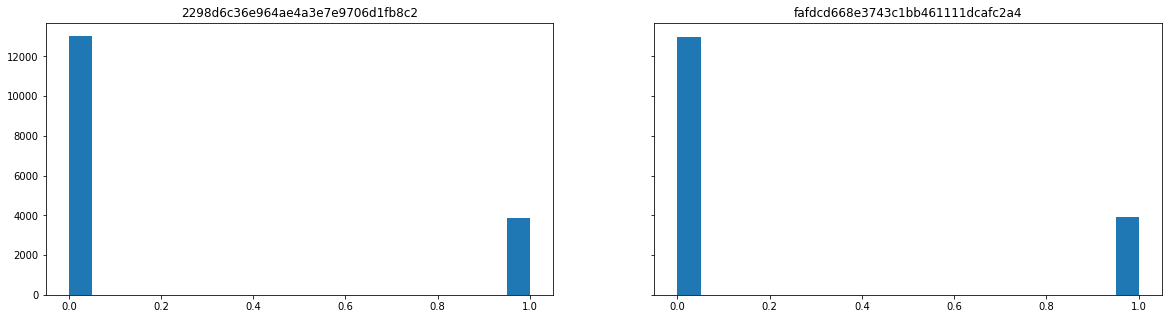

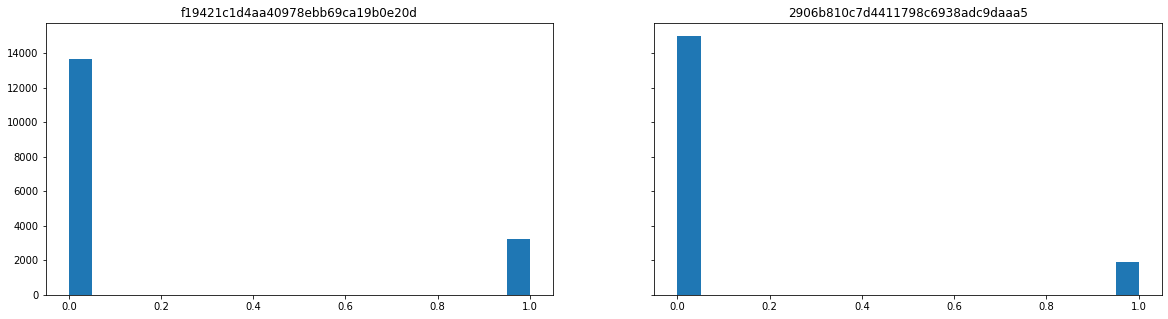

In [26]:
plot_hist(target_coupon)

This distribution tells us the data is imbalanced, in the prediction model we need to address this

Now let's safe the target data to a `csv` file

In [27]:
target_coupon.to_csv('training_data/target.csv')

##### 2. Consumer Spending Trend

We are now able to get all the transaction information. 
Based on this we can get the daily spending of each consumer

We use our helper function from the file `helper/data_cleaning.py`, `generate_consumer_trend` to do so, this function will take a transcript event from the `transcript` dataframe and organize it by time

In [28]:
consumer_trend_day_df = generate_consumer_trend(transcript)

In [29]:
consumer_trend_day_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
consumer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,22.16,...,0.0,0.00,14.11,13.56,10.27,0.00,0.00,12.36,28.16,18.41
00116118485d4dfda04fdbaba9a87b5c,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.00,0.00,0.00,0.0,13.49,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,22.05,0.00,23.03,8.96,0.00,0.00
0020c2b971eb4e9188eac86d93036a77,0.0,0.00,49.63,24.39,0.0,0.00,24.31,0.0,0.0,0.00,...,0.0,17.24,33.86,0.00,0.00,0.00,0.00,0.00,0.00,47.43
0020ccbbb6d84e358d3414a3ff76cffd,0.0,16.27,0.00,0.00,0.0,0.00,0.00,0.0,0.0,11.65,...,0.0,0.00,0.00,0.00,0.00,10.32,0.00,0.00,7.47,0.00


We now have the consumer trend of each day.

Save the consumer trend info to `consumer_trend_day.csv` for later use

In [30]:
consumer_trend_day_df.to_csv('assets/consumer_trend_day.csv')

##### Digging more into the spending trend

What can we gain from the trend?

Let's take a close look at the spending trend of each consumer.

For example, let's plot the spending activity of consumer `0009655768c64bdeb2e877511632db8f` and consumer `0020ccbbb6d84e358d3414a3ff76cffd`

In [31]:
consumer_1 = consumer_trend_day_df.loc['0009655768c64bdeb2e877511632db8f']
consumer_2 = consumer_trend_day_df.loc['0020ccbbb6d84e358d3414a3ff76cffd']

consumer_1_viewed = list(viewed_trend_day_df.loc['0009655768c64bdeb2e877511632db8f'])
for i, viewed in enumerate(consumer_1_viewed):
    if viewed =='':
        consumer_1_viewed[i] = 0
    else:
        consumer_1_viewed[i] = 10

        
consumer_2_viewed = list(viewed_trend_day_df.loc['0020ccbbb6d84e358d3414a3ff76cffd'])
for i, viewed in enumerate(consumer_2_viewed):
    if viewed =='':
        consumer_2_viewed[i] = 0
    else:
        consumer_2_viewed[i] = 10

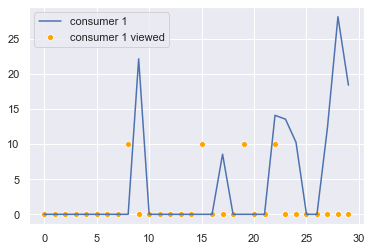

In [32]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.scatterplot(consumer_1.index, consumer_1_viewed, ax=ax, label='consumer 1 viewed', color='orange')
sns.lineplot(consumer_1.index, consumer_1.values, ax=ax, label='consumer 1')

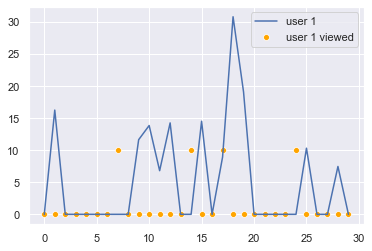

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(consumer_2.index, consumer_2_viewed, ax=ax, label='user 1 viewed', color='orange')
sns.lineplot(consumer_2.index, consumer_2.values, ax=ax, label='user 1')

An observation:

It seems like if there is a `coupon view` event, it is likely to have more spending right after it. The spending seems to be associate with `coupon view`, how do we describe this? Here is my suggestion:

##### Coupon Sensitivity

Based on this data visualization, we can tell the `view` activity has so what a connection to the spending activity:

For these 2 consumer, at least, it looks like `more spending activities are followed by the view acitivity`.

It will be helpful to create a feature to describe this phenomenon - `Coupon Sensitivity`

Here is how it works:

For the duration of the coupon (in the following days), how much `more` does this person spend compare to the purchase that are not initiated by the coupon - those purchases not in the following days of a coupon view event.

Formula for `coupon sensitivity`

`(avg_couponx_effective_spend - avg_spend_without_coupon) / coupon_difficulty`

- avg_couponx_effective_spend: if a consumer views a coupon, if he/she spend in the following days within its duration, these amount are called couponx_effective_spend, we then take the average.

- avg_spend_without_coupon: if a consumer spend on coffee in the days that are not affect by ANY coupon

- coupon difficulty: the difficulty of completing the coupon, this is to normalize each coupon

Follow the steps and we can get this feature:

##### 1. Calculate all non affected by coupon days

In [34]:
days_not_affect_by_coupon = get_days_not_affect_by_coupon(viewed_trend_day_df, portfolio)

In [35]:
days_not_affect_by_coupon

,days_not_affect_by_coupon
consumer_id,
085efb39e80140f08b90e0d77299958b,"[14, 15, 16, 17, 18]"
5ba3a50bd56d4309954af2555b32e536,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"
0eed1b43c7924182a635f0597fdf2adf,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
c9eed1f79316414183383096b7a95347,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
341d5d291e4d413ebea827b44c57fe4a,"[16, 29, 14, 15]"
...,...
c62168760f1642cc89a1b884409d50c9,"[0, 1, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 19, ..."
52373a9fea6348d583b6e4fb8c20e34a,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0cb086ad62d34af1b8a3fc1860e4215f,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 21, 22]"


Now we have a table of each consumer's days not affected by any coupon

##### 2. Calculating each person's `avg_spend_without_coupon`

In [36]:
consumer_sensitivity = cal_avg_spend_without_coupon(consumer_trend_day_df, days_not_affect_by_coupon)
consumer_sensitivity

,avg_spend_without_coupon
consumer_id,
0009655768c64bdeb2e877511632db8f,1.714
00116118485d4dfda04fdbaba9a87b5c,0.000
0011e0d4e6b944f998e987f904e8c1e5,0.000
0020c2b971eb4e9188eac86d93036a77,0.000
0020ccbbb6d84e358d3414a3ff76cffd,10.860
...,...
fff3ba4757bd42088c044ca26d73817a,0.000
fff7576017104bcc8677a8d63322b5e1,0.000
fff8957ea8b240a6b5e634b6ee8eafcf,0.846


A quick visualization:

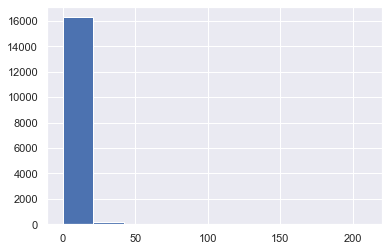

In [37]:
consumer_sensitivity['avg_spend_without_coupon'].hist()

Since the algorithm is rather complex, I wrap everything into the `generate_coupon_sensitivity` function, this is what it does:

- just like the way we calculate `avg_spend_without_coupon`, we calculate `avg_spending_affected by each coupon`, respectively

- We use the formular above, `(avg_couponx_effective_spend - avg_spend_without_coupon) / coupon_difficulty`, to calculate 
`coupon_sensitivity`

Below is the implementation, you can check out the helper file to see the details.

In [38]:
generate_coupon_sensitivity(consumer_sensitivity, viewed_trend_day_df, portfolio, consumer_trend_day_df)
consumer_sensitivity = consumer_sensitivity[consumer_sensitivity.columns[-8:]]
consumer_sensitivity

,ae264e3637204a6fb9bb56bc8210ddfd_type_sensitivity,4d5c57ea9a6940dd891ad53e9dbe8da0_type_sensitivity,9b98b8c7a33c4b65b9aebfe6a799e6d9_type_sensitivity,0b1e1539f2cc45b7b9fa7c272da2e1d7_type_sensitivity,2298d6c36e964ae4a3e7e9706d1fb8c2_type_sensitivity,fafdcd668e3743c1bb461111dcafc2a4_type_sensitivity,f19421c1d4aa40978ebb69ca19b0e20d_type_sensitivity,2906b810c7d4411798c6938adc9daaa5_type_sensitivity
consumer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,-0.171400,-0.1714,-0.342800,-0.0857,-0.244857,1.039475,0.764000,-0.171400
00116118485d4dfda04fdbaba9a87b5c,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.015556,0.000000
0011e0d4e6b944f998e987f904e8c1e5,0.000000,0.0000,1.544000,0.2702,0.243469,0.000000,0.000000,0.000000
0020c2b971eb4e9188eac86d93036a77,0.000000,0.3448,0.000000,0.0000,0.000000,0.983300,0.000000,0.000000
0020ccbbb6d84e358d3414a3ff76cffd,-1.086000,-1.0860,-1.579000,-0.5430,-0.600612,-1.086000,0.000000,-1.086000
...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.000000,0.0000,1.276286,0.0000,0.000000,1.333900,0.000000,0.000000
fff7576017104bcc8677a8d63322b5e1,0.029714,0.2100,0.000000,0.0000,0.000000,0.133842,0.000000,0.000000
fff8957ea8b240a6b5e634b6ee8eafcf,-0.084600,-0.0846,-0.169200,-0.0423,-0.120857,-0.003700,-0.169200,-0.084600


##### Consumer Sensitivity Visualization

Let's plot the histogram of Consumer Sensitivity

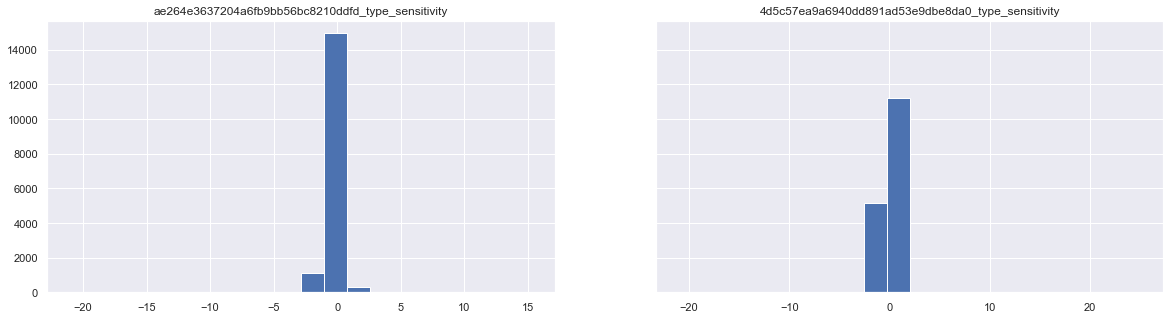

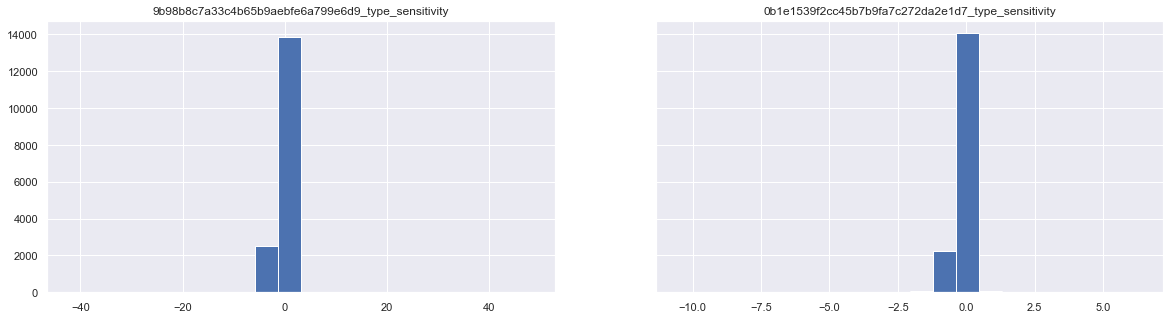

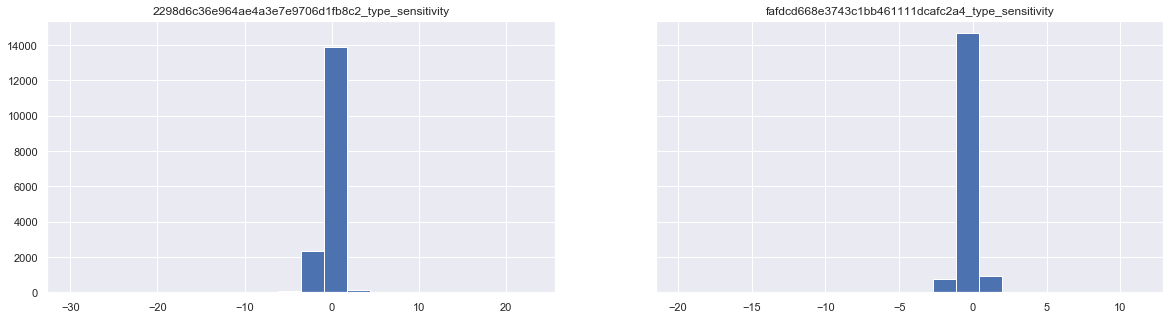

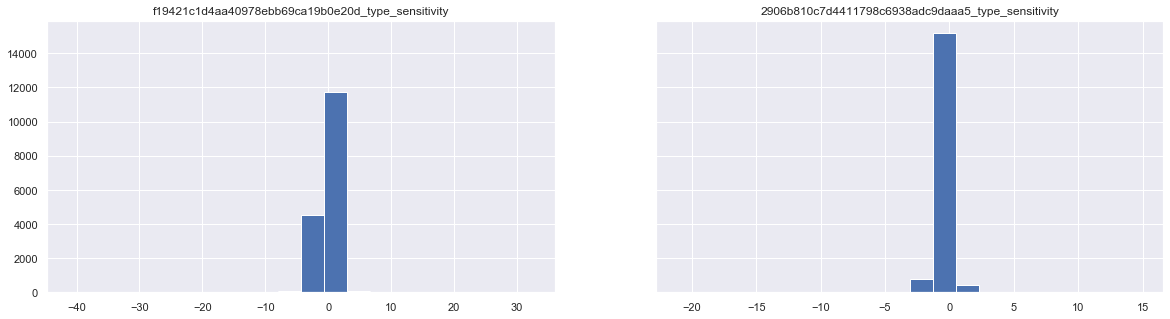

In [39]:
plot_hist(consumer_sensitivity)

In [40]:
consumer_sensitivity.to_csv('training_data/consumer_sensitivity.csv')

### Refinement

Now that we have the target information and coupon sensitivity, there is still room for improvement: We can get more features from the consumer trend information we generated.

Based on the trend, we are able to create more features we think may help the modeling

#### Consumer Trend Features

Create a table that contains the following features, these are some basic statistial features that we may be able to use 

- Avg Daily spending: The mean of spending of each day
- Highest daily spending: The max of daily spending
- Lowest daily spending: The min of daily spending
- std_daily_spending: The standard deviation of daily spending
- Count days no spending: The number of days consumer did not spend on starbucks coffee
- count days spending 0_to_5: The number of days consumer spend 0 - 5 on starbucks coffee
- count days spending 5_to_10: The number of days consumer spend 5 - 10 on starbucks coffee
- count days spending 10_to_15: The number of days consumer spend 10 - 15 on starbucks coffee
- count days spending 15_to_20: The number of days consumer spend 15 - 20 on starbucks coffee
- count days spending 20_plus: The number of days consumer spend 20 plus on starbucks coffee

In [41]:
from helper.data_cleaning import generate_consumer_data
feature_group = generate_consumer_data(consumer_trend_day_df)
feature_group.head()

,Avg Daily spending,Highest daily spending,Lowest daily spending,count days no spending,count days spending 0_to_5,count days spending 5_to_10,count days spending 10_to_15,count days spending 15_to_20,count days spending 20_plus,std_daily_spending
consumer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,4.253333,28.16,8.57,22.0,0.0,1.0,1.0,1.0,2.0,7.867232
00116118485d4dfda04fdbaba9a87b5c,0.136333,3.39,0.70,28.0,2.0,0.0,0.0,0.0,0.0,0.627653
0011e0d4e6b944f998e987f904e8c1e5,2.648667,23.03,8.96,25.0,0.0,1.0,1.0,0.0,2.0,6.461309
0020c2b971eb4e9188eac86d93036a77,6.562000,49.63,17.24,24.0,0.0,0.0,0.0,1.0,5.0,14.444319
0020ccbbb6d84e358d3414a3ff76cffd,5.135000,30.84,6.81,19.0,0.0,3.0,3.0,2.0,1.0,7.923300


##### Feature Group Visualization

Let's plot the histogram of these data

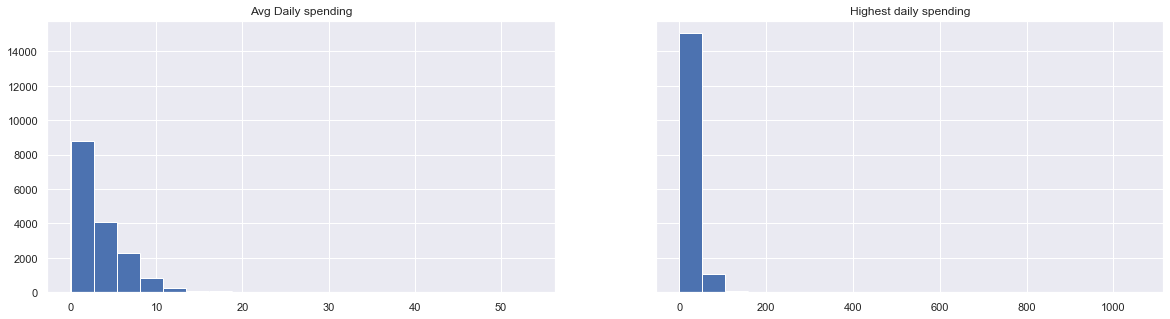

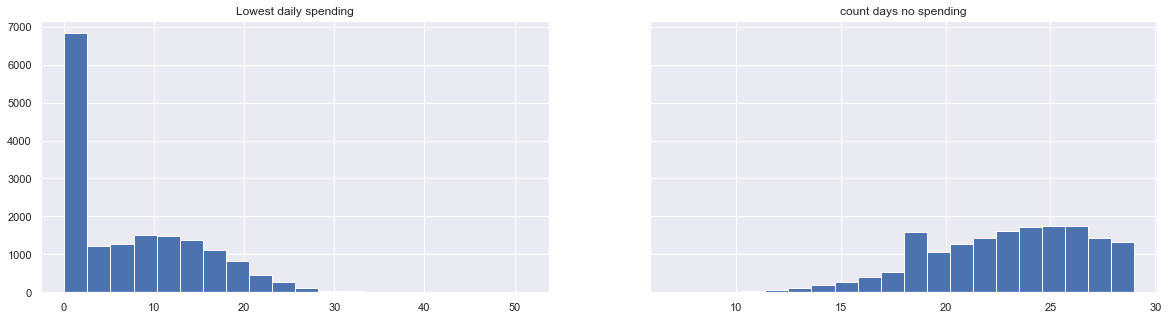

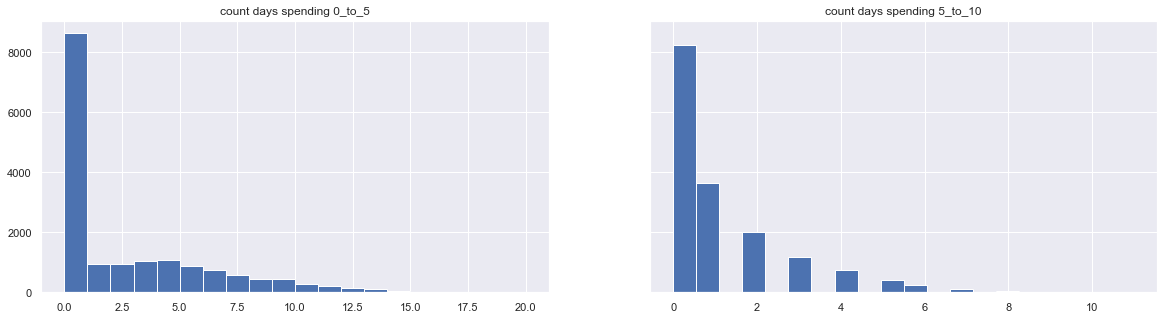

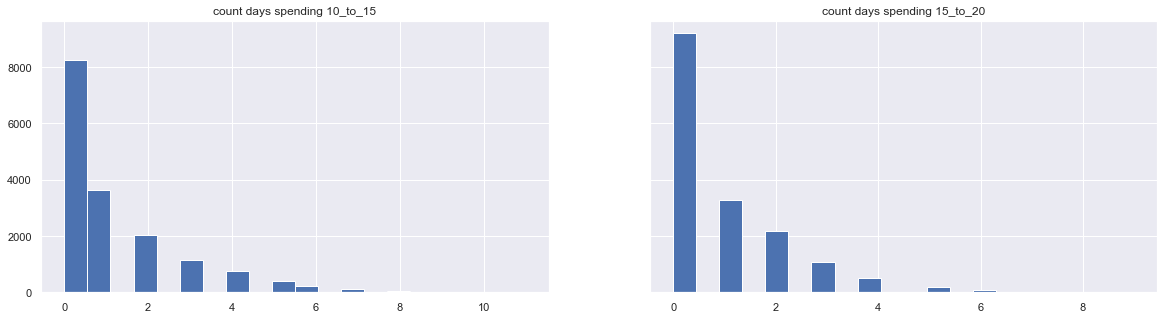

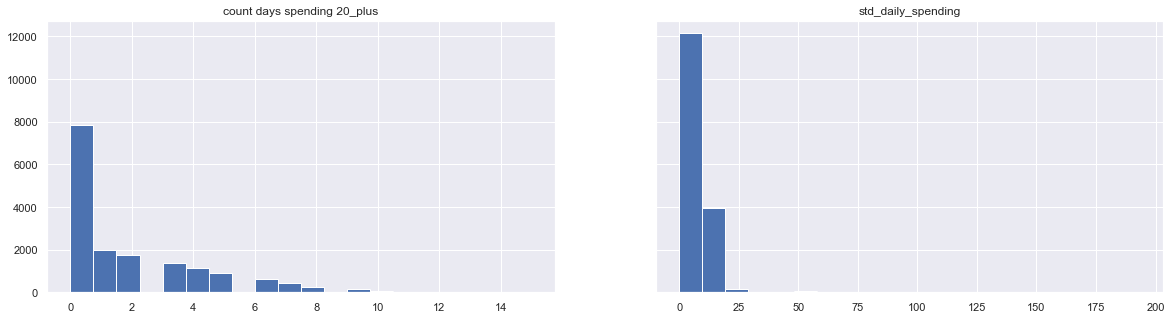

In [42]:
plot_hist(feature_group)

In [43]:
feature_group.to_csv('training_data/consumer_features.csv')

In the following result section, we will join 

-- portfolio

|

-- profile

|

-- consumer_sensitivity

|

-- feature_group

To become a dataframe that contains the target and the feature for each consumer / coupon relationship

## 4. Result

### Model Evaluation and Validation

We will perform the following steps for our Training (evaluation metrix: with ROC_AUC / Recall / Accuracy):

 1. Prepare the traing data, join all features and target into 1 dataframe
 2. We will first run a KNN only based on all features
 3. We apply random forest classifier on other target coupons and run a feature importance analysis on features, if necessary, we reduce the dimension using PCA
 4. Improve with Hyper-parameter tuning (Optional)
 5. Wrap the models to a single function that takes a consumer id and return the best coupon for this consumer
     - I will use the mathematic expectation, fomula:
     
         `expectation = roc_auc * difficulty` 
         
         (the more difficult, the more that consumer will spend)

#### 1. Prepare Training

We need to get the data that are from the dataset and from our previous analysis:

- `profile`, after running clean_profile function
- `portfolio`, after running clean_portfolio function
- `consumer_features`, where we created from our data analysis
- `consumer_sensitivity`, created from our visualization and analysis
- `target` from the target data we just created

In [44]:
consumer_feature = pd.read_csv('training_data/consumer_features.csv', index_col='consumer_id')

consumer_sensitivity = pd.read_csv('training_data/consumer_sensitivity.csv', index_col='consumer_id')

target = pd.read_csv('training_data/target.csv', index_col='consumer_id')

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.datasets import make_classification

from helper.data_cleaning import clean_profile, clean_portfolio, join_coupon_profile_data, join_consumer_data
from helper.training import calc_coupon_x_consumer_data, run_predict_random_forest, run_predict_knn

Here is how we organize all the data:

for each coupon type in `target`, we join the target data and all features we just created correspond with the specific consumer using our helper function `calc_coupon_x_consumer_data`, for example:

In [46]:
# Calculate coupon 1 : ae264e3637204a6fb9bb56bc8210ddfd
coupon_0_consumer_data = calc_coupon_x_consumer_data(0, portfolio, profile, target, consumer_feature, consumer_sensitivity)
coupon_0_consumer_data

,ae264e3637204a6fb9bb56bc8210ddfd,Avg Daily spending,Highest daily spending,Lowest daily spending,count days no spending,count days spending 0_to_5,count days spending 5_to_10,count days spending 10_to_15,count days spending 15_to_20,count days spending 20_plus,...,110000-120000,120000-130000,ae264e3637204a6fb9bb56bc8210ddfd_type_sensitivity,4d5c57ea9a6940dd891ad53e9dbe8da0_type_sensitivity,9b98b8c7a33c4b65b9aebfe6a799e6d9_type_sensitivity,0b1e1539f2cc45b7b9fa7c272da2e1d7_type_sensitivity,2298d6c36e964ae4a3e7e9706d1fb8c2_type_sensitivity,fafdcd668e3743c1bb461111dcafc2a4_type_sensitivity,f19421c1d4aa40978ebb69ca19b0e20d_type_sensitivity,2906b810c7d4411798c6938adc9daaa5_type_sensitivity
consumer_id,,,,,,,,,,,,,,,,,,,,,
0eed1b43c7924182a635f0597fdf2adf,0,0.742667,4.71,0.77,20.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.020000,-0.0200,-0.040000,-0.0100,0.311633,-0.020000,0.56760,-0.020000
c9eed1f79316414183383096b7a95347,0,0.472667,5.33,1.32,25.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0000,0.000000,0.0000,0.159524,0.000000,0.00000,0.000000
7d074f93492e43e6aa923e6516b449ab,0,5.712333,19.34,2.93,15.0,2.0,5.0,5.0,4.0,0.0,...,0.0,0.0,-1.075800,-1.0758,-2.151600,-0.5379,-0.776041,-0.469633,-1.44480,-1.075800
210fe4b56f4c4e868cebde8685add8d9,0,0.213333,3.92,1.16,27.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.09920,0.000000
fb28844eb6c544139eebc3974b4ee74a,1,9.701667,33.00,10.26,13.0,0.0,0.0,0.0,4.0,4.0,...,0.0,0.0,0.743629,-0.4258,-0.851600,-0.2129,1.049265,-0.425800,1.23765,-0.425800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e8b1e52456bf44a29f67a21fd02e6ebf,0,1.964333,19.40,3.74,25.0,1.0,1.0,1.0,2.0,0.0,...,0.0,0.0,-0.225600,-0.2256,-0.087600,-0.1128,0.618531,-0.225600,0.00000,-0.225600
f4d2cc6759ff4ada82765afea30d8662,0,2.260667,15.58,0.52,15.0,11.0,2.0,2.0,1.0,0.0,...,0.0,0.0,-0.094000,0.5072,-0.188000,-0.0470,0.498571,-0.094000,0.07640,-0.094000
c9926c915da94155924e1272c59d20e5,0,0.987000,6.79,0.61,21.0,8.0,1.0,1.0,0.0,0.0,...,0.0,0.0,-0.087800,-0.0878,-0.175600,-0.0439,0.094333,-0.087800,-0.17560,-0.087800


Now we have created a dataframe for traning coupon `ae264e3637204a6fb9bb56bc8210ddfd`, the 1st column is the target coupon, and all the other columns are features, we now have 14219 rows × 68 columns, which is a good size of features that we can train on.

#### 2. Training on Benchmark Model

Let's run KNN classifier on our traning data, I am using KNN as it is one of the commonly used algorithm for this type of problem and it is fast. I have wrap the classifier in `run_predict_knn` function.

This function will take the index of the coupon, and join all features and target and run the prediction model, then print out the score for:

- `roc_auc`
- `accuracy`
- `recall`
- `precision`
- `f1 score`

In [47]:
for i in range(8):  # run though each coupon index
    run_predict_knn(i, portfolio, profile, target, consumer_feature, consumer_sensitivity)

coupon ae264e3637204a6fb9bb56bc8210ddfd
roc_auc score is 0.5662508510845249
accuracy score is 0.826769807782466
recall score is 0.18115942028985507
precision score is 0.4180602006688963
f1 score is 0.2527805864509606
---------------------------------------------------------------
coupon 4d5c57ea9a6940dd891ad53e9dbe8da0
roc_auc score is 0.5669563642669211
accuracy score is 0.8145804031879981
recall score is 0.18860244233378562
precision score is 0.4186746987951807
f1 score is 0.2600561272217025
---------------------------------------------------------------
coupon 9b98b8c7a33c4b65b9aebfe6a799e6d9
roc_auc score is 0.5594945606856833
accuracy score is 0.8734177215189873
recall score is 0.13489208633093525
precision score is 0.5597014925373134
f1 score is 0.21739130434782605
---------------------------------------------------------------
coupon 0b1e1539f2cc45b7b9fa7c272da2e1d7
roc_auc score is 0.5111807091342211
accuracy score is 0.9207688701359588
recall score is 0.032467532467532464
prec

##### 3. Random Forest Prediction & Feature Importance

The result is not satisfying. Let's perform a feature importance analysis and a random forest prediction.

- First trial with coupon `ae264e3637204a6fb9bb56bc8210ddfd`

Execute run_predict_random_forest function. This function will take the index of the coupon, and join all features and target and run the prediction model, plot the feature importance (top 20 features) and evaluate our data then print out the score for:

- `roc_auc`
- `accuracy`
- `recall`
- `precision`
- `f1 score`

coupon ae264e3637204a6fb9bb56bc8210ddfd
roc_auc score is 0.9243106215348701
accuracy score is 0.9446788560712611
recall score is 0.8942028985507247
precision score is 0.791025641025641
f1 score is 0.8394557823129251
---------------------------------------------------------------


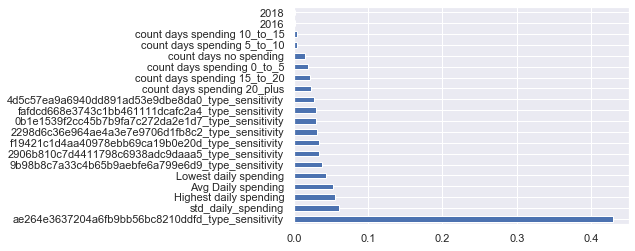

In [48]:
coupon_0_clf = run_predict_random_forest(0, portfolio, profile, target, consumer_feature, consumer_sensitivity)

##### We have found out that `sensitivity` is a really important features, it is determistic to our model.

Because the multi-label classifier is rather harsh in sklearn, we will perform the same algorithm on each target coupon.

- coupon `4d5c57ea9a6940dd891ad53e9dbe8da0`

coupon 4d5c57ea9a6940dd891ad53e9dbe8da0
roc_auc score is 0.9273370902769954
accuracy score is 0.9517112048757619
recall score is 0.8900949796472184
precision score is 0.8399487836107554
f1 score is 0.8642951251646903
---------------------------------------------------------------


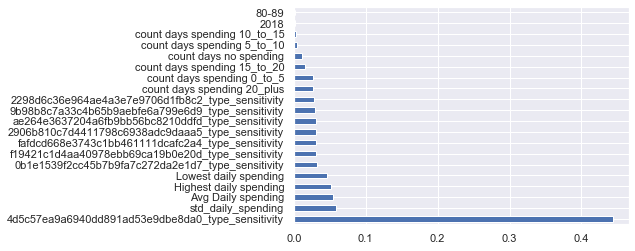

In [49]:
coupon_1_clf = run_predict_random_forest(1, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `9b98b8c7a33c4b65b9aebfe6a799e6d9`

coupon 9b98b8c7a33c4b65b9aebfe6a799e6d9
roc_auc score is 0.8963718513060172
accuracy score is 0.950070323488045
recall score is 0.8237410071942446
precision score is 0.7993019197207679
f1 score is 0.8113374667847653
---------------------------------------------------------------


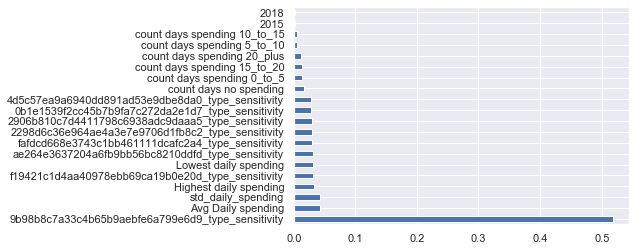

In [50]:
coupon_2_clf =run_predict_random_forest(2, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `0b1e1539f2cc45b7b9fa7c272da2e1d7`

coupon 0b1e1539f2cc45b7b9fa7c272da2e1d7
roc_auc score is 0.912331920227322
accuracy score is 0.9678856071261135
recall score is 0.8474025974025974
precision score is 0.7435897435897436
f1 score is 0.7921092564491653
---------------------------------------------------------------


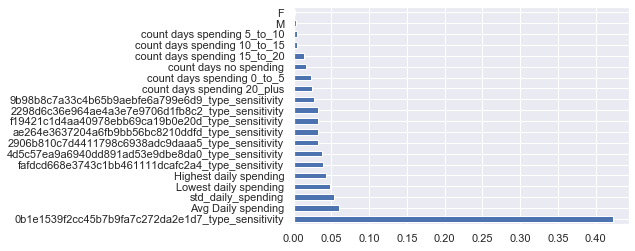

In [51]:
coupon_3_clf = run_predict_random_forest(3, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `2298d6c36e964ae4a3e7e9706d1fb8c2`

coupon 2298d6c36e964ae4a3e7e9706d1fb8c2
roc_auc score is 0.9259377698838176
accuracy score is 0.9406938584153774
recall score is 0.8961038961038961
precision score is 0.8726287262872628
f1 score is 0.8842105263157893
---------------------------------------------------------------


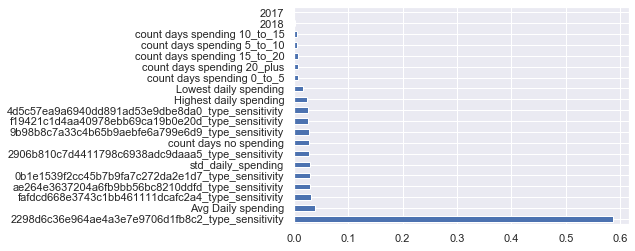

In [52]:
coupon_4_clf = run_predict_random_forest(4, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `fafdcd668e3743c1bb461111dcafc2a4`

coupon fafdcd668e3743c1bb461111dcafc2a4
roc_auc score is 0.9225262170371265
accuracy score is 0.9371776840131271
recall score is 0.8927911275415896
precision score is 0.8640429338103757
f1 score is 0.8781818181818182
---------------------------------------------------------------


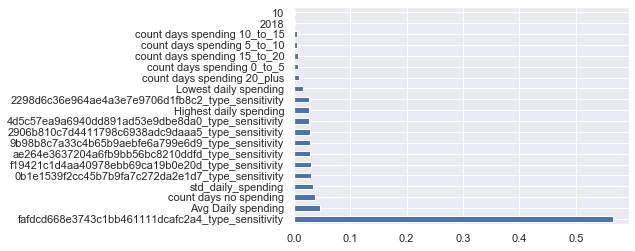

In [53]:
coupon_5_clf = run_predict_random_forest(5, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `f19421c1d4aa40978ebb69ca19b0e20d`

coupon f19421c1d4aa40978ebb69ca19b0e20d
roc_auc score is 0.9151391144627473
accuracy score is 0.9388185654008439
recall score is 0.874439461883408
precision score is 0.8396124865446717
f1 score is 0.85667215815486
---------------------------------------------------------------


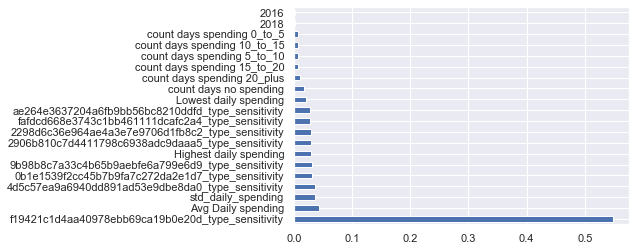

In [54]:
coupon_6_clf = run_predict_random_forest(6, portfolio, profile, target, consumer_feature, consumer_sensitivity)

- coupon `2906b810c7d4411798c6938adc9daaa5`

coupon 2906b810c7d4411798c6938adc9daaa5
roc_auc score is 0.9129944764042102
accuracy score is 0.9549929676511955
recall score is 0.8566176470588235
precision score is 0.803448275862069
f1 score is 0.8291814946619217
---------------------------------------------------------------


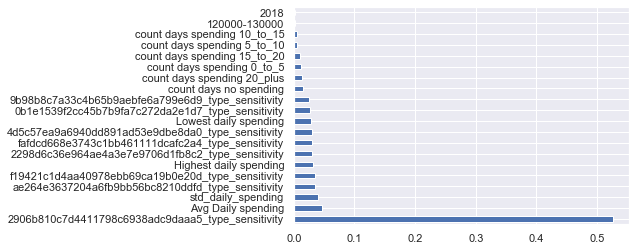

In [55]:
coupon_7_clf = run_predict_random_forest(7, portfolio, profile, target, consumer_feature, consumer_sensitivity)

All the results are looking good (roc_auc 90% +), I will skip the hyperopt and jump on to the final wrapping function.

##### 5. Wrap the models to a single function that takes a consumer id and return the best coupon for this consumer

 - This function will combine all the random forest classifiers, and then run prediction on a given consumer_id (new data), then make a prediction;
 - If several classfiers returns true, it will take the one that has the highest mathematic expectation

In [57]:
CLF_LIST = [
    coupon_0_clf,
    coupon_1_clf,
    coupon_2_clf,
    coupon_3_clf,
    coupon_4_clf,
    coupon_5_clf,
    coupon_6_clf,
    coupon_7_clf
]

def recommend_coupon_to_consumer(consumer_id, clf_list):
    
    expectations = []
    
    for clf in clf_list:
        
        pred = clf['clf'].predict(clf['consumer_data'].loc[[consumer_id], clf['consumer_data'].columns[1:]])[0]
        difficulty = clf['consumer_data'].loc[consumer_id, 'difficulty']
        roc_auc = clf['roc_auc']
    
        expectations.append(pred * difficulty * roc_auc)
        
    max_i = 0
    max_e = expectations[max_i]
    
    for i, e in enumerate(expectations):
        if e > max_e:
            # update max_i and max_e
            max_i = i
            max_e = e
    
    best = clf_list[max_i]['consumer_data'].columns[0]
    print(f'best coupon for the consumer is: {best}, consumer expected spend is {max_e} ' )
    return best


from sklearn.externals import joblib
for i, clf in enumerate(CLF_LIST):
    joblib.dump(clf, f'out/models/coupon_{i+1}_classifier.sav')

### Justification

Our model is way better than the benchmark, while the `KNN` model only have slightly better than `50%` of `roc_auc`, our models are `90% +`, average `30% - 40%` better than the benchmark model. Same applies to `recall score`, `precision score` and `f1 score`


## 5. Conclusion

At this point, we are confident to say we have a good model to recommend a coupon for a consumer, as long as we have some historic data of this consumer.


### Reflection

There are important learning that we can get from this project:

- Feature Engineering is the key: When you don't get good results, do not give up, there might be a way to interpret the data differently that can significantly improve the result (like `coupon_sensitivity` in this case, if we don't use it, the result would be a disaster)

- Visualization is helpful: Visualization can help you get a lot of insights, and lead you to the key features

- Ask the right question: One of the difficult part of this project is to ask the right question: 
    - what is the target and how do you figure it out based on the original data? Once we know what is a meaningful problem to solve, we are half way to the solution

    

### Improvement

- Hyper Parameter Tuning
    - We did not do any hyper parameter tuning on this project as the result is already good. But it definitely can improve the result even more
  
- Try CNNhe 
    - Although we don't have tons of data entry, it would be a good method if we have more data from Starbucks
  
- Make An App
    - A next step to this project would be deploy this model to `sagemaker` and expose it as a `lambda function`. If Starbucks provide more data, we can keep updating the model and keep making it better

## 6. Deployment

Save the model to pickle and make a flask app (TODO)